In [1]:
import pygmt
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load Mars topography data from MOLA dataset
mars_topography = xr.open_dataset("mola32.nc")

In [ ]:
# Check the dataset
print(mars_topography)

<xarray.Dataset> Size: 133MB
Dimensions:    (latitude: 5760, longitude: 11520)
Coordinates:
  * latitude   (latitude) float32 23kB 89.98 89.95 89.92 ... -89.95 -89.98
  * longitude  (longitude) float32 46kB 0.01562 0.04688 0.07812 ... 360.0 360.0
Data variables:
    alt        (latitude, longitude) int16 133MB ...
Attributes:
    title:    MOLA Topography - 32 pixels/degree
    history:  Built from original MOLA file megt90n000fb.img


In [ ]:
# CREATE A SCATTER PLOT 
# Load the datasets
hend = pd.read_csv("hend_aggregated.csv")
water = pd.read_csv("water_concentration_normalized.csv")

# Renaming columns for merging
water = water.rename(columns={"LATITUDE": "lat", "LONGITUDE": "lon"})

# Merging the datasets on latitude and longitude
merged = pd.merge(hend, water, on=["lat", "lon"])


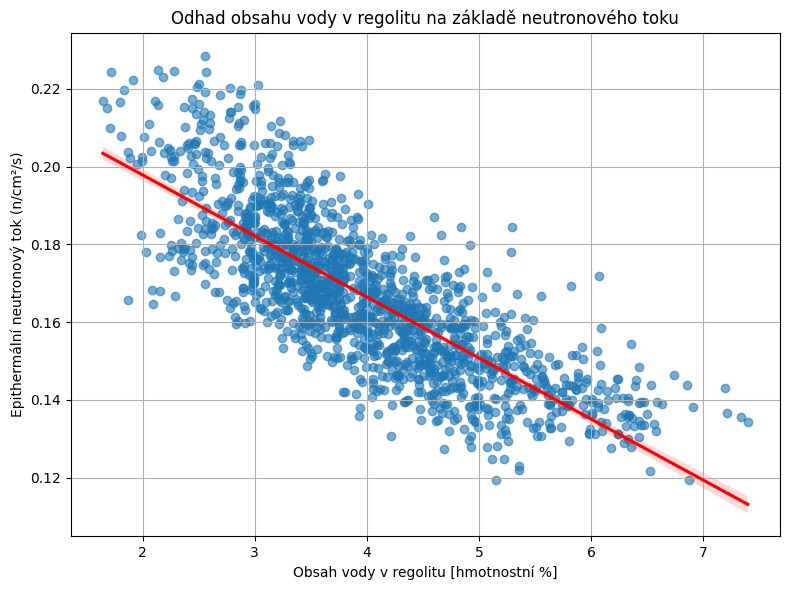

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=merged,
    x="CONCENTRATION",
    y="EPITHERMAL_FLUX2",
    scatter_kws={"alpha": 0.6},
    line_kws={"color": "red"}
)
plt.xlabel("Obsah vody v regolitu [hmotnostní %]")
plt.ylabel("Epithermální neutronový tok (n/cm²/s)")
plt.title("Odhad obsahu vody v regolitu na základě neutronového toku")
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\marke\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\core\duck_array_ops.py:230: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
colorbar [WARNING]: Option -B: Cannot use +f for Cartesian axes - modifier ignored
colorbar [WARNING]: Option -B: Cannot use +f for Cartesian axes - modifier ignored


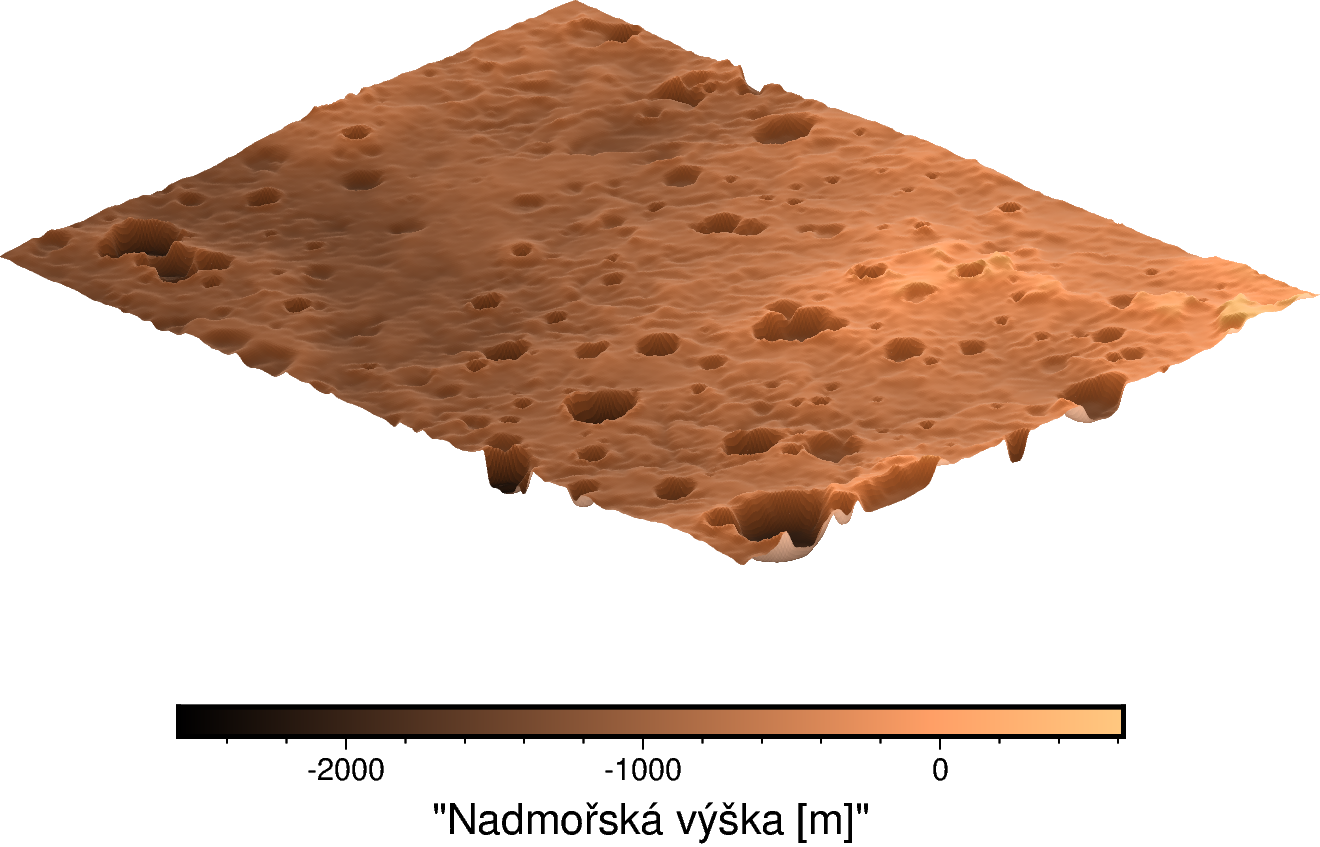

In [ ]:
# CREATE A 3D VIEW OF MERIDIANI PLANUM
# Subregion selection for Meridiani Planum
region = [-10, 10, -10, 5]
alt = mars_topography["alt"].sel(
    longitude=slice(region[0], region[1]),
    latitude=slice(region[3], region[2])
)

# Smooth the terrain (e.g., using a rolling window of 3 grid points ≈ 5°)
alt_smoothed = alt.rolling(latitude=3, longitude=3, center=True).mean()
# Interpolate to finer resolution for better visualization
alt_interp = pygmt.grdsample(
    grid=alt_smoothed,
    spacing="0.05/0.05",
    region=region,
    registration="gridline"
)

# Initialize the figure
fig = pygmt.Figure()

# 3D surface view of the topography
fig.grdview(
    grid=alt_smoothed,
    region=region,
    projection="X14c/9c",
    perspective=[225, 25],
    zscale=0.0002,
    surftype="s",
    shading="+a45+nt0.5",
    frame=False,
    cmap="copper",
)

# Colorbar for elevation values
fig.colorbar(
    frame=["af", 'x+l"Nadmořská výška [m]"+f4p,Helvetica'],
    position="JBC+o2.4c/-1.2c+w8c/0.25c",
    
    box=False
)
fig.show()


C:\Users\marke\AppData\Local\Temp\ipykernel_11524\2739398021.py:25: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(
text [WARNING]: Latitude (92) at line # 1 exceeds -|+ 90! - set to NaN


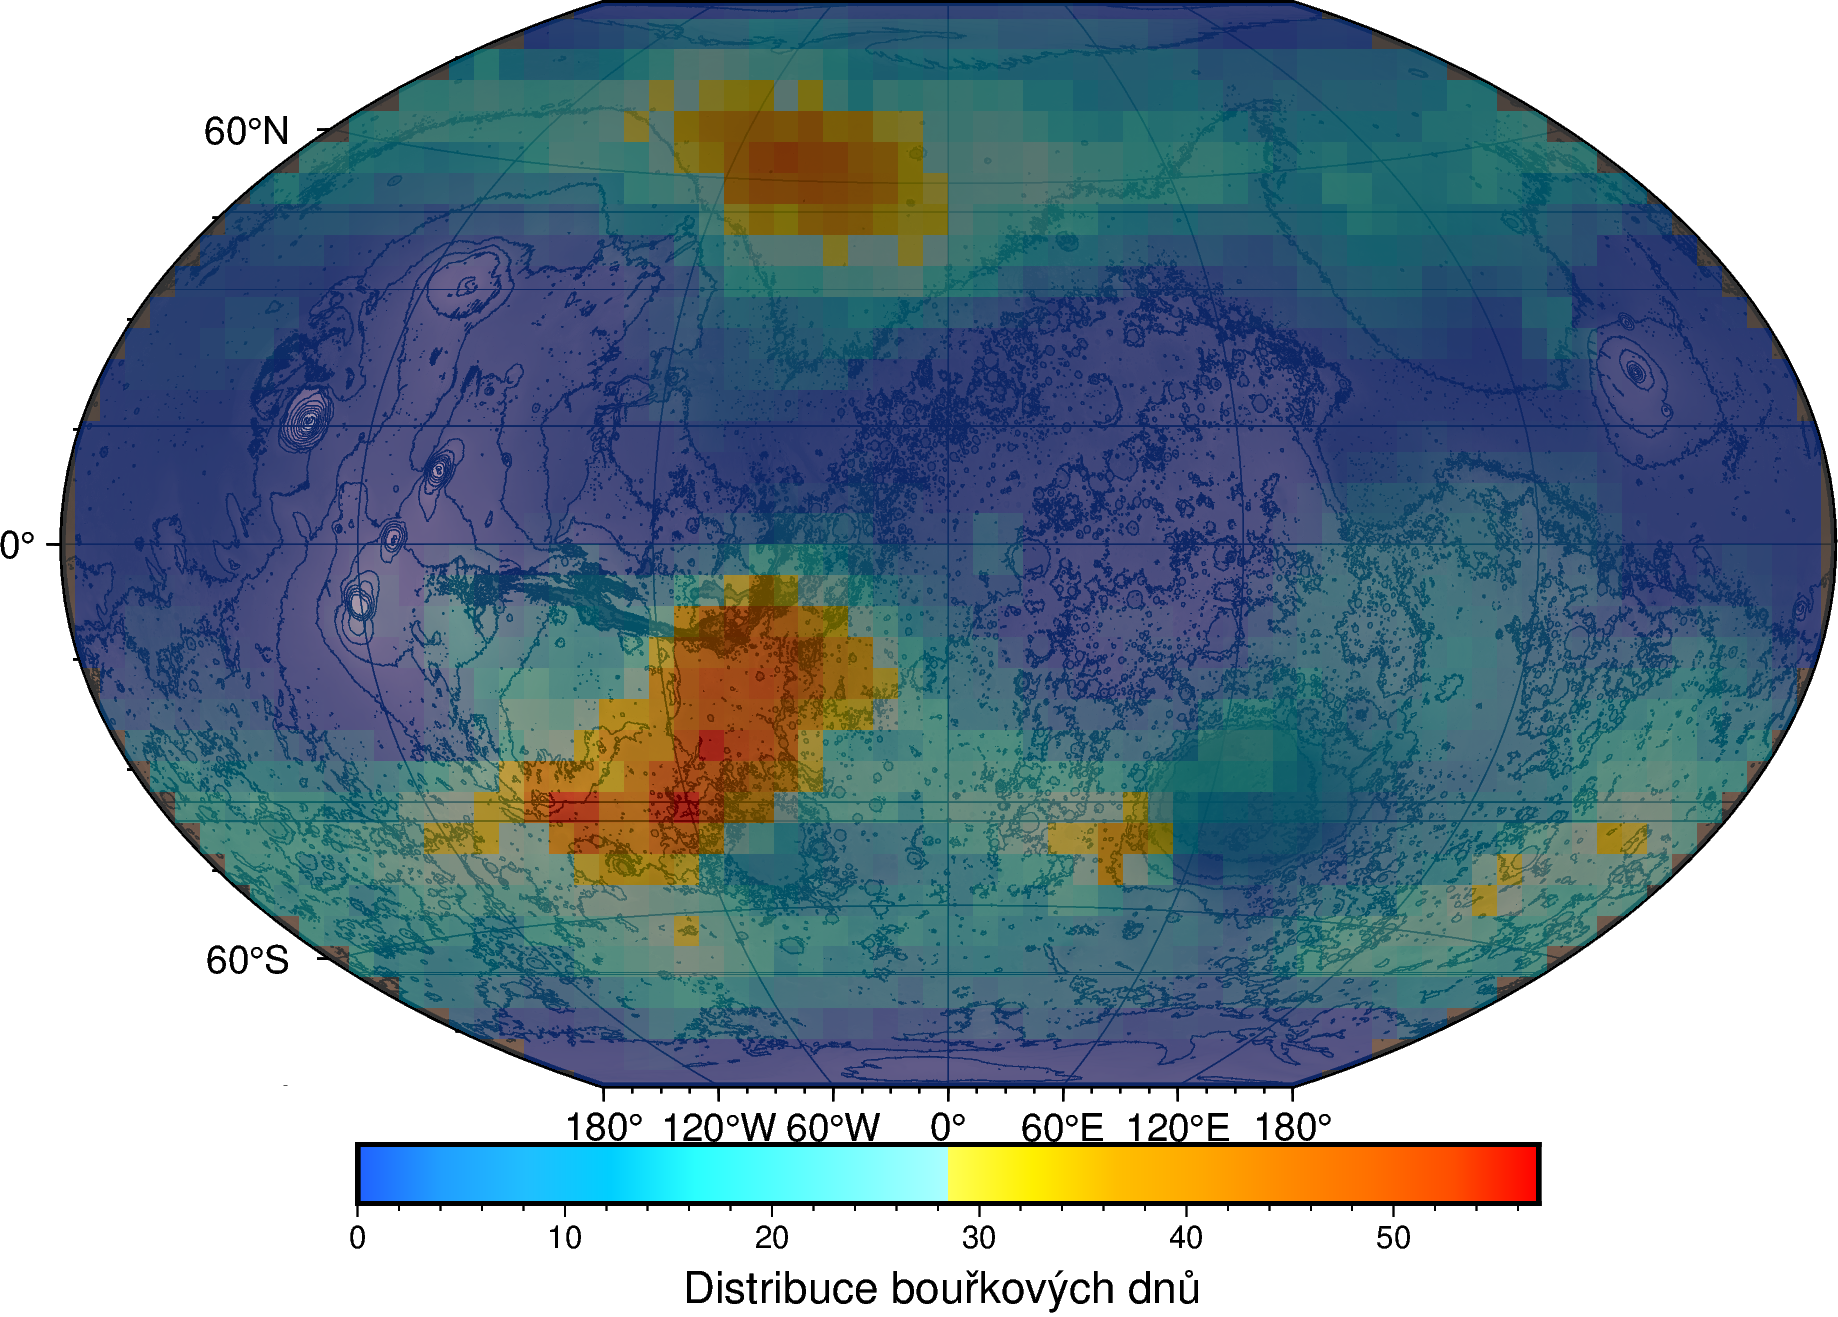

In [ ]:
# CREATE A MAP
# Load the dataset
dust = pd.read_csv("storm_summary_5x5_days_normalized.csv")

# Pivot the thorium data into a 2D grid format
grid_df = dust.pivot(index="lat", columns="lon", values="stormy_days")
grid_df = grid_df.rename_axis(index="latitude", columns="longitude")

# Convert the grid to an xarray DataArray
grid_xr = xr.DataArray(
    grid_df,
    coords={"latitude": grid_df.index, "longitude": grid_df.columns},
    dims=["latitude", "longitude"]
)

# Initialize the figure
fig = pygmt.Figure()

# Global topographic map of Mars
fig.grdimage(
    grid=mars_topography["alt"].sortby("latitude"),
    cmap="copper",
    projection="R15c",
    region=[-180, 180, -90, 90],
    frame=["xafg", "yafg"]
)

# Contour lines for elevation
fig.grdcontour(
    grid=mars_topography["alt"].sortby("latitude"),
    interval=2000,
    pen="0.2p,black"
)

# Show grid with colormap and transparency
fig.grdimage(
    grid=grid_xr,
    cmap="no_green",
    transparency=60
)
# Add colorbar below with label
fig.colorbar(
    frame=["af", "x+lDistribuce bouřkových dnů "],
    position="JBC+o0c/0.5c+w10c/0.5c+h"
)

# Locations of interest
#locations = {
 #   "Meridiani Planum": (5.4, 0.2),
 #   "Oyama Crater": (-19.579, 23.468)
#}
#for name, (lon, lat) in locations.items():
#    fig.plot(x=lon, y=lat, style="c0.3c", fill="white")
#    fig.text(x=lon, y=lat, text=name, font="8p,Helvetica-Normal,white", offset="0.3c/0.3c", justify="LM")
 
# Title above the map    
fig.text(
    x=0, y=92,  
    text="Distribuce bouřkových dnů na Marsu",
    font="14p,Helvetica-Bold,black",
    justify="CT"
)

# Show the final map
fig.show()